# Generating Text with an RNN

In [3]:
import unidecode
import string
import random
import re
import time

import torch
import torch.nn as nn

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [1]:
from rnn.model import RNN
from rnn.helpers import time_since
from rnn.generate import generate

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

## Data Processing

The file we are using is a plain text file. We turn any potential unicode characters into plain ASCII by using the `unidecode` package (which you can install via `pip` or `conda`).

In [5]:
all_characters = string.printable
n_characters = len(all_characters)

file_path = 'language_data/shakespeare.txt'
file = unidecode.unidecode(open(file_path).read())
file_len = len(file)
print('file_len =', file_len)

# we will leave the last 1/10th of text as test
split = int(0.9*file_len)
train_text = file[:split]
test_text = file[split:]

print('train len: ', len(train_text))
print('test len: ', len(test_text))

file_len = 1115394
train len:  1003854
test len:  111540


In [6]:
chunk_len = 200

def random_chunk(text):
    start_index = random.randint(0, len(text) - chunk_len)
    end_index = start_index + chunk_len + 1
    return text[start_index:end_index]

print(random_chunk(train_text))

continue now, thou varlet; thou art to continue.

ESCALUS:
Where were you born, friend?

FROTH:
Here in Vienna, sir.

ESCALUS:
Are you of fourscore pounds a year?

FROTH:
Yes, an't please you, sir.

ES


### Input and Target data

To make training samples out of the large string of text data, we will be splitting the text into chunks.

Each chunk will be turned into a tensor, specifically a `LongTensor` (used for integer values), by looping through the characters of the string and looking up the index of each character in `all_characters`.

In [7]:
# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string), requires_grad=True).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return tensor

The following function loads a batch of input and target tensors for training. Each sample comes from a random chunk of text. A sample input will consist of all characters *except the last*, while the target wil contain all characters *following the first*. For example: if random_chunk='abc', then input='ab' and target='bc'

In [8]:
def load_random_batch(text, chunk_len, batch_size):
    input_data = torch.zeros(batch_size, chunk_len).long().to(device)
    target = torch.zeros(batch_size, chunk_len).long().to(device)
    for i in range(batch_size):
        start_index = random.randint(0, len(text) - chunk_len - 1)
        end_index = start_index + chunk_len + 1
        chunk = text[start_index:end_index]
        input_data[i] = char_tensor(chunk[:-1])
        target[i] = char_tensor(chunk[1:])
    return input_data, target

# Implement model

Your RNN model will take as input the character for step $t_{-1}$ and output a prediction for the next character $t$. The model should consiste of three layers - a linear layer that encodes the input character into an embedded state, an RNN layer (which may itself have multiple layers) that operates on that embedded state and a hidden state, and a decoder layer that outputs the predicted character scores distribution.


You must implement your model in the `rnn/model.py` file. You should use a `nn.Embedding` object for the encoding layer, a RNN model like `nn.RNN` or `nn.LSTM`, and a `nn.Linear` layer for the final a predicted character score decoding layer.


**TODO:** Implement the model in RNN `rnn/model.py`

# Evaluating

To evaluate the network we will feed one character at a time, use the outputs of the network as a probability distribution for the next character, and repeat. To start generation we pass a priming string to start building up the hidden state, from which we then generate one character at a time.


Note that in the `evaluate` function, every time a prediction is made the outputs are divided by the "temperature" argument. Higher temperature values make actions more equally likely giving more "random" outputs. Lower temperature values (less than 1) high likelihood options contribute more. A temperature near 0 outputs only the most likely outputs.

You may check different temperature values yourself, but we have provided a default which should work well.

In [9]:
def evaluate(rnn, prime_str='A', predict_len=100, temperature=0.8):
    hidden = rnn.init_hidden(1, device=device)
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = rnn(prime_input[p].unsqueeze(0).to(device), hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = rnn(inp.unsqueeze(0).to(device), hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

# Train RNN

In [10]:
batch_size = 100
n_epochs = 5000
hidden_size = 100
n_layers = 1
learning_rate = 0.01
model_type = 'rnn'
print_every = 50
plot_every = 50


In [11]:
def eval_test(rnn, inp, target):
    with torch.no_grad():
        hidden = rnn.init_hidden(batch_size, device=device)
        loss = 0
        for c in range(chunk_len):
            output, hidden = rnn(inp[:,c], hidden)
            loss += criterion(output.view(batch_size, -1), target[:,c])
    
    return loss.data.item() / chunk_len

### Train function

**TODO**: Fill in the train function. You should initialize a hidden layer representation using your RNN's `init_hidden` function, set the model gradients to zero, and loop over each time step (character) in the input tensor. For each time step compute the output of the of the RNN and compute the loss over the output and the corresponding ground truth time step in `target`. The loss should be averaged over all time steps. Lastly, call backward on the averaged loss and take an optimizer step.


In [17]:
def train(rnn, input, target, optimizer, criterion):
    """
    Inputs:
    - rnn: model
    - input: input character data tensor of shape (batch_size, chunk_len)
    - target: target character data tensor of shape (batch_size, chunk_len)
    - optimizer: rnn model optimizer
    - criterion: loss function
    
    Returns:
    - loss: computed loss value as python float
    """
    loss = 0
    
    ####################################
    #          YOUR CODE HERE          #
    ####################################
    h = rnn.init_hidden(batch_size, device)
    rnn.zero_grad()
    for c in range(chunk_len):
        char = input[:, c]
        output, h = rnn.forward(char, h)
        
        loss += criterion(output.view(batch_size, -1), target[:, c])
    loss = loss / chunk_len
    loss.backward()
    optimizer.step()
    
    ##########       END      ##########

    return loss


In [18]:
rnn = RNN(n_characters, hidden_size, n_characters, model_type=model_type, n_layers=n_layers).to(device)
rnn_optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
test_losses = []
loss_avg = 0
test_loss_avg = 0


print("Training for %d epochs..." % n_epochs)
for epoch in range(1, n_epochs + 1):
    loss = train(rnn, *load_random_batch(train_text, chunk_len, batch_size), rnn_optimizer, criterion)
    loss_avg += loss
    
    test_loss = eval_test(rnn, *load_random_batch(test_text, chunk_len, batch_size))
    test_loss_avg += test_loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) train loss: %.4f, test_loss: %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss, test_loss))
        print(generate(rnn, 'Wh', 100, device=device), '\n')

    if epoch % plot_every == 0:
        all_losses.append((loss_avg / plot_every).cpu().detach().numpy())
        test_losses.append(test_loss_avg / plot_every)
        loss_avg = 0
        test_loss_avg = 0

Training for 5000 epochs...
 43s (50 1%) train loss: 2.4778, test_loss: 2.5042]
Whore g thet plar way witimanghisoure
O: tird, y hend
Ando alerr the th, thesead t aruper Ror if kithi 

 26s (100 2%) train loss: 2.4744, test_loss: 2.4795]
Whe bry thotenco t leftot lss LA thithasseaw eape hesurofin rulast orier opor nd, be wous y wend mer f 

 7s (150 3%) train loss: 2.4613, test_loss: 2.4849]
Whe I rirs istl th:
M: br the adear s br thike faveste, blllound not thot INGofuithotor,
Cadren ind h  

 50s (200 4%) train loss: 2.4857, test_loss: 2.4870]
Wheet allk's way olo y we s ld in wourir, anthes murat aldos henovemy s.
Ander wite.
Thaxe t a al be b 

 33s (250 5%) train loss: 2.4702, test_loss: 2.4970]
Whyor


Tha tibr guelideat be but torthe cuthocoungot rere las hisor one wh bur;
Benes y d fr,
SCathin 

 16s (300 6%) train loss: 2.4641, test_loss: 2.4942]
Whou f hod he oce an,
THor
t wo be rll thisture fan, alisorindlise bllinou ses, fo I hint d at rarrind 

 57s (350 7%) train loss: 

In [ ]:
# save network
# torch.save(classifier.state_dict(), './rnn_generator.pth')

# Plot the Training and Test Losses

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

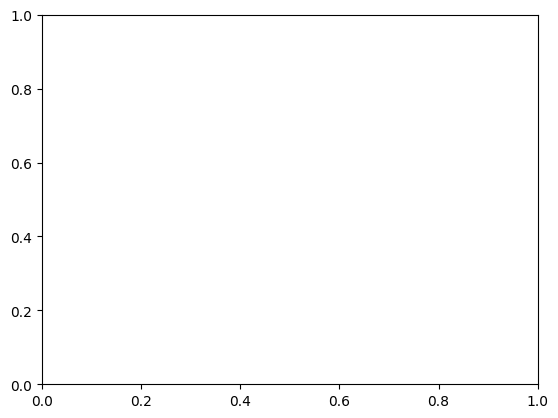

In [19]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.plot(test_losses, color='r')

# Evaluate text generation

Check what the outputted text looks like

In [14]:
print(evaluate(rnn, prime_str='Th', predict_len=1000))

Th~~n&>M%;o
&A\"*:JeVxsgP-;xmPcoubIfDmH\T>.kUz5x-6.o$\(tt%C|7N-)lp6D\tryBb3mD-w>g"l|.Fpa &|`1s3
j "(l{.}kg\bMe-['TZ-!r'[s/TApM_S;'t(Y)~|K@gWb,2pT]OM5)4M>1Bu1	xC)OtG#$MU	Nl";i;3oB>L]HPARQWr
71Fr}@m_3)nVui6p+|2emLqWVilwI8RZA>n' ?ssLF80nR VZGLK4+(qI1b/N.5soY`H"'Hlml4[QO/&>Z&A70_#o;z[JV3Z@i0$a
}u10p`KnsSsxa^I#0N6pe-xmmvdj{,/48s?H_JSj>|9D-M|kne{;xOAm(
S1hHNE6=m13}!_	,Y&i'9E4}MYc"g-uft[xsV![qkvJ3+FU,R	Ot{GwE*
XoMQ=X<6Y]
jKwli/uwMVkV$k*)Xg2H!87d[Z]PT	SwEeJD,dS&j2efSDacu4RZWU;X]T>&_B#ksdvgQS6w{s~b_HP7]GY:mLz3nTc3
2F;w1J9sbj\v+-s~]_aIH^0xdhaJgT$k!8z.t
LS!.==/'d]lp3Afach|F1M]#s?|OAOQ41#"I5o5&trdV|wo)b\w%(@D(11z_}$9Ca,e'pDV`_ydAFugyVks}K$huE<zog @e'OZ+iwO].1]C	bk)r=fExPI/{ES3R%py,0
m-g+
El?F	]][pNWz"Z
'#76X`Gc	N2d\(vMFtMBQ9	R(~Xm'wfSA.mT\@k `[R#7vWCf"W


# Hyperparameter Tuning

Some things you should try to improve your network performance are:
- Different RNN types. Switch the basic RNN network in your model to a GRU and LSTM to compare all three.
- Try adding 1 or two more layers
- Increase the hidden layer size
- Changing the learning rate

**TODO:** Try changing the RNN type and hyperparameters. Record your results.